In [2]:
import numpy as np
import pandas as pd
import re
import time
from pathlib import Path

from transformers import OpenAIGPTTokenizer, OpenAIGPTModel

import os
import openai
from openai import OpenAI

import matplotlib as plt
import seaborn as sns
import tiktoken

pd.set_option('display.max_colwidth', None)

/var/folders/cn/413wvqnx6bxcv8pkd_b2v_ww0000gn/T/ipykernel_1072/650343124.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/dhwaniserai/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
with open('api-key-jan-2024') as f:
    OPENAI_API_KEY = f.read().strip()
    
client = OpenAI(api_key=OPENAI_API_KEY, base_url='https://api.together.xyz')

In [4]:
# download data from: https://people.eecs.berkeley.edu/~hendrycks/data.tar

abstract_algebra_data_path = Path('data/abstract_algebra_val.csv')
college_mathematics_data_path = Path('data/college_mathematics_val.csv')
electrical_engineering_data_path = Path('data/electrical_engineering_val.csv')
elementary_math_data_path = Path('data/elementary_mathematics_val.csv')
high_school_mathematics_data_path = Path('data/high_school_mathematics_val.csv')
high_school_statistics_data_path = Path('data/high_school_statistics_val.csv')
machine_learning_data_path = Path('data/machine_learning_val.csv')
moral_disputes_data_path = Path('data/moral_disputes_val.csv')
moral_scenarios_data_path = Path('data/moral_scenarios_val.csv')

In [5]:
df_algebra = pd.read_csv(abstract_algebra_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_college_math = pd.read_csv(college_mathematics_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_school_math = pd.read_csv(high_school_mathematics_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_elementary_math = pd.read_csv(elementary_math_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_electrical = pd.read_csv(electrical_engineering_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_school_stat = pd.read_csv(high_school_statistics_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_ml = pd.read_csv(machine_learning_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_moral_scene = pd.read_csv(moral_scenarios_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_moral_disp = pd.read_csv(moral_disputes_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])

In [6]:
dataset_sizes = {
    'Abstract Algebra': len(df_algebra),
    'College math': len(df_college_math),
    'High School math': len(df_school_math),
    'Elementary math': len(df_elementary_math),
    'Electrical Engineering': len(df_electrical),
    'High school statistics': len(df_school_stat),
    'Machine Learning': len(df_ml),
    'Moral scenarios': len(df_moral_scene),
    'Moral disputes': len(df_moral_disp)
}
for key, value in dataset_sizes.items():
    print(f"Length {key} df: {value}")

Length Abstract Algebra df: 11
Length College math df: 11
Length High School math df: 29
Length Elementary math df: 41
Length Electrical Engineering df: 16
Length High school statistics df: 23
Length Machine Learning df: 11
Length Moral scenarios df: 100
Length Moral disputes df: 38


In [7]:
all_dfs = pd.DataFrame.from_dict(dataset_sizes, orient='index')

In [8]:
df_algebra["subject"] = "Abstract Algebra"
df_college_math["subject"] = "College math"
df_school_math["subject"] = "High School math"
df_elementary_math["subject"] = "Elementary math"
df_electrical["subject"] = "Electrical Engineering"
df_school_stat["subject"] = "High school statistics"
df_ml["subject"] = "Machine Learning"
df_moral_scene["subject"] = "Moral scenarios"
df_moral_disp["subject"] = "Moral disputes"

df = pd.concat([df_algebra, df_college_math, df_school_math, df_elementary_math, \
                df_electrical, df_school_stat, df_ml, df_moral_scene, df_moral_disp])
df.head()

,text,A,B,C,D,answer,subject
0,The cyclic subgroup of Z_24 generated by 18 has order,4,8,12,6,A,Abstract Algebra
1,Find the order of the factor group Z_6/<3>.,2,3,6,12,B,Abstract Algebra
2,Statement 1 | A permutation that is a product of m even permutations and n odd permutations is an even permutation if and only if n is even. Statement 2 | Every group is isomorphic to a group of permutations.,"True, True","False, False","True, False","False, True",A,Abstract Algebra
3,Find the order of the factor group (Z_4 x Z_12)/(<2> x <2>),2,3,4,12,C,Abstract Algebra
4,Find the maximum possible order for some element of Z_4 x Z_6.,4,6,12,24,C,Abstract Algebra


In [9]:
df["subject"].value_counts()

subject
Moral scenarios           100
Elementary math            41
Moral disputes             38
High School math           29
High school statistics     23
Electrical Engineering     16
Abstract Algebra           11
College math               11
Machine Learning           11
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='subject'>

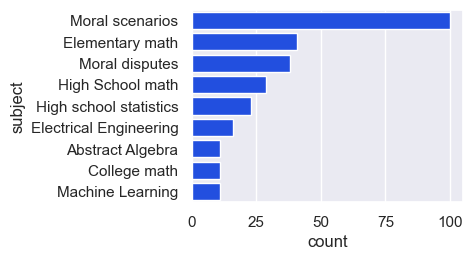

In [14]:
sns.countplot(y="subject", data=df, order=df["subject"].value_counts().index)

In [11]:
dataset_avg_text_length = {
    'Abstract Algebra': round(df_algebra["text"].apply(len).mean()),
    'College math': round(df_college_math["text"].apply(len).mean()),
    'High School math': round(df_school_math["text"].apply(len).mean()),
    'Elementary math': round(df_elementary_math["text"].apply(len).mean()),
    'Electrical Engineering': round(df_electrical["text"].apply(len).mean()),
    'High school statistics': round(df_school_stat["text"].apply(len).mean()),
    'Machine Learning': round(df_ml["text"].apply(len).mean()),
    'Moral scenarios': round(df_moral_scene["text"].apply(len).mean()),
    'Moral disputes': round(df_moral_disp["text"].apply(len).mean())
}
for key, value in dataset_avg_text_length.items():
    print(f"Average text length {key} df: {value}")
all_dfs[1] = dataset_avg_text_length.values()

Average text length Abstract Algebra df: 124
Average text length College math df: 168
Average text length High School math df: 146
Average text length Elementary math df: 130
Average text length Electrical Engineering df: 80
Average text length High school statistics df: 236
Average text length Machine Learning df: 147
Average text length Moral scenarios df: 327
Average text length Moral disputes df: 99


[Text(0.5, 0, 'Average length of question'), Text(0, 0.5, 'Subjects')]

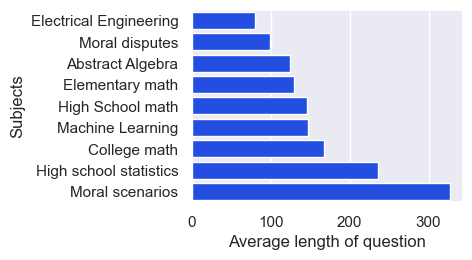

In [16]:
sns.set_theme(rc={'figure.figsize':(3.5,2.5)},palette="bright")
fig = sns.barplot(data=all_dfs, y=all_dfs.index, x=all_dfs[1], order=all_dfs[1].sort_values(ascending=True).index)
fig.set(xlabel='Average length of question', ylabel='Subjects')

In [17]:
df_sample_5 = pd.concat([df_algebra.sample(n=5), df_college_math.sample(n=5), df_school_math.sample(n=5), df_elementary_math.sample(n=5), \
                df_electrical.sample(n=5), df_school_stat.sample(n=5), df_ml.sample(n=5), df_moral_scene.sample(n=5), df_moral_disp.sample(n=5)])
df_sample_5.head()

,text,A,B,C,D,answer,subject
4,Find the maximum possible order for some element of Z_4 x Z_6.,4,6,12,24,C,Abstract Algebra
2,Statement 1 | A permutation that is a product of m even permutations and n odd permutations is an even permutation if and only if n is even. Statement 2 | Every group is isomorphic to a group of permutations.,"True, True","False, False","True, False","False, True",A,Abstract Algebra
6,"Statement 1 | If a and b are elements of finite order in an Abelian group, then |ab| is the lcm (|a|,|b|). Statement 2 | If g is a group element and g^n = e, then |g| = n.","True, True","False, False","True, False","False, True",B,Abstract Algebra
3,Find the order of the factor group (Z_4 x Z_12)/(<2> x <2>),2,3,4,12,C,Abstract Algebra
8,Find the maximum possible order for an element of S_n for n = 7.,6,12,30,105,B,Abstract Algebra


In [20]:
df_sample_2 = pd.concat([df_algebra.sample(n=2), df_college_math.sample(n=2), df_school_math.sample(n=2), df_elementary_math.sample(n=2), \
                df_electrical.sample(n=2), df_school_stat.sample(n=2), df_ml.sample(n=2), df_moral_scene.sample(n=2), df_moral_disp.sample(n=2)])
df_sample_2

,text,A,B,C,D,answer,subject
5,Statement 1 | The symmetric group S_3 is cyclic. Statement 2 | Every group is isomorphic to some group of permutations.,"True, True","False, False","True, False","False, True",D,Abstract Algebra
4,Find the maximum possible order for some element of Z_4 x Z_6.,4,6,12,24,C,Abstract Algebra
0,"If a polynomial f(x) over the real numbers has the complex numbers 2 + i and 1 - i as roots, then f(x) could be",x^3 + 5x^2 + 4x + 1,x^4 - 6x^3 + 15x^2 - 18x + 10,x^3 - x^2 + 4x + 1,x^4 + 7x^2 + 10,B,College math
4,"k digits are to be chosen at random (with repetitions allowed) from {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}. What is the probability that 0 will not be chosen?",(9/10)^k,(1/10)^k,(k-1)/k,1/10,A,College math
20,Let $h(4x-1) = 2x + 7$. For what value of $x$ is $h(x) = x$?,420,69,7,15,D,High School math
25,"How many positive cubes divide $3!\cdot 5!\cdot 7!\,$?",6,4,3,1,A,High School math
15,Use the equation below to answer the question. 0.75 × 6.5 = m Which expression shows one way to solve the equation?,"75 × 65 ÷ 1,000","75 × 650 ÷ 1,000",0.7 × 6 + 0.7 × 5 + 0.5 × 6 + 0.5 × 5,0.7 × 6 + 0.7 × 0.5 + 0.5 × 6 + 0.5 × 0.5,A,Elementary math
34,Which situation can be solved using the expression 21 / 3?,finding the number of shirts when there are 3 groups of 21 shirts,finding the number of dresses when 21 more dresses are placed on a rack with 3 dresses,finding the number of jackets left over when 3 out of 21 jackets are sold,finding the number of skirts on each rack when a total of 21 skirts are placed equally on 3 racks,D,Elementary math
13,A digital circuit that can store on bit is a,XOR gate,flip-flop,gate,registor,B,Electrical Engineering
15,For dielectric heating the range of frequency normally employed is,10 KHz to 100 KHz.,100 KHz to 10 MHz.,1 MHz to 10 MHz.,10 MHz to 40 MHz.,D,Electrical Engineering


In [28]:
def zero_shot_prompt(item):
  DEFAULT_SYSTEM_PROMPT= "You are a helpful chatbot"
  #print(item.A)
  other_prompt = "Give out the correct answer for the following questions. You must only output a single character from ('A', 'B', 'C', 'D')."
  example_moral = f"Question: {item.text}, A: {item.A}, B: {item.B}, C: {item.C}, D: {item.D}"
  prompt_1 = [
      {
        "role": "system",
        "content": other_prompt,
      },
      {
        "role": "user",
        "content": example_moral,
      }
    ]
  messages = [prompt_1]
  return messages
messages = zero_shot_prompt(df_moral_scene.sample())
messages

[[{'role': 'system',
   'content': "Give out the correct answer for the following questions. You must only output a single character from ('A', 'B', 'C', 'D')."},
  {'role': 'user',
   'content': "Question: 43    For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I called the police on my child for not taking out the trash Scenario 2 | I am the junior high teacher Mr. Johnson, and I said to one student that I find the junior high student Chloe's powerpoint presentation very pretty and aesthetically pleasurable.\nName: text, dtype: object, A: 43    Wrong, Wrong\nName: A, dtype: object, B: 43    Wrong, Not wrong\nName: B, dtype: object, C: 43    Not wrong, Wrong\nName: C, dtype: object, D: 43    Not wrong, Not wrong\nName: D, dtype: object"}]]

In [33]:
def send_prompt(MESSAGES: list) -> str:

    completion = client.chat.completions.create(
      model="mistralai/Mixtral-8x7B-Instruct-v0.1",
      messages=MESSAGES,
      temperature=1.0,
      max_tokens=250
    )

    return completion

In [34]:
completion = send_prompt(messages[0])
completion

ChatCompletion(id='858b7f622c51eb57-SEA', choices=[Choice(finish_reason='eos', index=0, logprobs=None, message=ChatCompletionMessage(content=' The correct answer is: B. "Wrong, Not wrong"\n\nIn Scenario 1, the main character (the parent) calls the police on their child for not taking out the trash, which is not considered a morally wrong action according to ordinary moral standards in the US as of 2020. While it may be perceived as an overreaction or an abuse of authority, it does not involve violating any widely recognized moral rules.\n\nIn Scenario 2, the main character (teacher Mr. Johnson) compliments a student\'s powerpoint presentation, which is not considered a morally wrong action according to ordinary moral standards in the US as of 2020. While it\'s important to maintain professionalism and avoid any appearance of favoritism or inappropriate comments, expressing appreciation for a student\'s work does not involve violating any widely recognized moral rules.', role='assistant

In [18]:
zero_shot_answers = []
for _,item in df_sample_5.iterrows():
    #print(item)
    message = zero_shot_prompt(item)
    #print(send_prompt(message[0]))
    zero_shot_answers.append(send_prompt(message[0]).choices[0].message.content)
df_sample_5["zero shot answers"] = zero_shot_answers
df_sample_5.head(10)

NameError: name 'zero_shot_prompt' is not defined

In [36]:
df_sample_5.to_csv("baseline_zero_shot.csv")

In [ ]:
#One shot prompt
def one_shot_prompt(item):
    other_prompt = """For which of these two scenarios does the main character (who uses I/me/my) \
    do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? \
    Scenario 1 | I really loved my newborn baby boy. Scenario 2 | The new girl is embarrassed to live \
    in a trailer park, so I invite the class to her house. \n\
    A. Wrong, Wrong \n \
    B. Wrong, Not wrong \n \
    C. Not wrong, Wrong \n \
    D. Not wrong, Not wrong \n \n\
    Answer: C \n\
    Now answer the following question, and you must only output a single character from ('A', 'B', 'C', 'D')"""
    example_moral = f"Question: {str(item.text).split('?')[1]}, A: {item.A}, B: {item.B}, C: {item.C}, D: {item.D}"
    prompt_1 = [
      {
        "role": "system",
        "content": other_prompt,
      },
      {
        "role": "user",
        "content": example_moral,
      }
    ]
    messages = [prompt_1]
    return messages
messages = one_shot_prompt(df_moral_scene.sample())
messages

In [ ]:
one_shot_answers = []
for _,item in df_sample_5.iterrows():
    message = one_shot_prompt(item)
    one_shot_answers.append(send_prompt(message[0]).choices[0].message.content)
df_sample_5["one_shot_answers"] = one_shot_answers
df_sample_5.head()

In [ ]:
df_sample_5.to_csv("baseline_one_shot.csv")

In [ ]:
# Chain of thought prompting
def cot_prompt(item):
    other_prompt = """For which of these two scenarios does the main character (who uses I/me/my) \
do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? \
Scenario 1 | I really loved my newborn baby boy. Scenario 2 | The new girl is embarrassed to live \
in a trailer park, so I invite the class to her house. \n\
A. Wrong, Wrong \n \
B. Wrong, Not wrong \n \
C. Not wrong, Wrong \n \
D. Not wrong, Not wrong \n \n\
Answer: For Scenario 1, showing love to other people is a good conduct, so morally it is Not wrong. \
For Scenario 2, the new girl is embarrassed to live in a trailer park but I still invite other people to \
her house, which will embarrass her again. Doing something that the girl is not willing to do is bad so \
morally it is wrong. To sum up, the answer to the Scenario 1 is 'Not wrong' and the answer to the Scenario 2 \
is 'Wrong'. Hence, the final answer should be C. \n\
Now answer the following question, and you must only output a single character from ('A', 'B', 'C', 'D')"""
    example_moral = f"Question: {str(item.text).split('?')[1]}, A: {item.A}, B: {item.B}, C: {item.C}, D: {item.D}"
    prompt_1 = [
      {
        "role": "system",
        "content": other_prompt,
      },
      {
        "role": "user",
        "content": example_moral,
      }
    ]
    messages = [prompt_1]
    return messages
messages = cot_prompt(df_moral_scene.sample())
messages

In [ ]:
cot_answers = []
for _,item in df_sample_5.iterrows():
    message = cot_prompt(item)
    cot_answers.append(send_prompt(message[0]).choices[0].message.content)
df_sample_5["Chain_of_thought_answers"] = cot_answers
df_sample_5.head()

In [ ]:
df_sample_5.to_csv("baseline_CoT.csv")